# 02 — Análise e Definição do Pré-Processamento

Projeto: Classificação de Pneumonia em Raio-X  

Arquivos utilizados:
- data/metadata/train_split.csv
- data/metadata/val_split.csv

Objetivo deste notebook:

1. Definir o pipeline de pré-processamento.
2. Aplicar:
   - Resize para 224x224
   - CenterCrop (remoção de bordas)
   - Normalização padrão ImageNet
   - Data augmentation leve (baseline)
3. Visualizar o impacto das transformações.
4. Preparar base para treinamento com ResNet18.

Todas as transformações serão posteriormente movidas
para src/transforms.py.


## 1. Definição do Diretório Raiz

Garantimos que todos os caminhos utilizados apontem
para a pasta raiz do projeto e não para notebooks/.


In [1]:
import os

NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, ".."))

print("Notebook está em:", NOTEBOOK_DIR)
print("Project root:", PROJECT_ROOT)


Notebook está em: c:\projects\xray-project\notebooks
Project root: c:\projects\xray-project


## 2. Carregamento dos Splits Congelados

Arquivos carregados:
- data/metadata/train_split.csv
- data/metadata/val_split.csv

Esses arquivos garantem que o conjunto de validação
permaneça fixo em todos os experimentos.


In [8]:
import pandas as pd

metadata_dir = os.path.join(PROJECT_ROOT, "data", "metadata")

train_df = pd.read_csv(os.path.join(metadata_dir, "train_split.csv"))
val_df = pd.read_csv(os.path.join(metadata_dir, "val_split.csv"))

print("Treino:", len(train_df))
print("Validação:", len(val_df))

train_df.head()


Treino: 4093
Validação: 1139


,filename,path,label,patient_id
0,NORMAL-1003233-0001.jpeg,c:\projects\xray-project\data\train\NORMAL\NOR...,0,1003233
1,NORMAL-1012843-0001.jpeg,c:\projects\xray-project\data\train\NORMAL\NOR...,0,1012843
2,NORMAL-1014768-0001.jpeg,c:\projects\xray-project\data\train\NORMAL\NOR...,0,1014768
3,NORMAL-1023731-0001.jpeg,c:\projects\xray-project\data\train\NORMAL\NOR...,0,1023731
4,NORMAL-1029510-0001.jpeg,c:\projects\xray-project\data\train\NORMAL\NOR...,0,1029510


## 3. Definição do Pré-Processamento (Baseline)

Aplicamos:

1. Resize para 224x224
   - Compatível com ResNet18 e DenseNet121

2. CenterCrop (90%)
   - Remove bordas onde podem existir letras,
     marcadores hospitalares e artefatos

3. Data augmentation leve:
   - HorizontalFlip
   - Rotação de até 5 graus

4. Normalização padrão ImageNet
   - Necessária para modelos pré-treinados


In [9]:
from torchvision import transforms

img_size = 224

train_transform_light = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    
    # Remove bordas externas que podem conter artefatos
    transforms.CenterCrop(int(img_size * 0.9)),
    
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    
    transforms.ToTensor(),
    
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.CenterCrop(int(img_size * 0.9)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


## 4. Visualização do Impacto do Pré-Processamento

Comparamos:

- Imagem original
- Imagem após resize, crop e normalização

O objetivo é verificar:

- Se as bordas foram reduzidas
- Se a imagem mantém estrutura anatômica


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2391288].


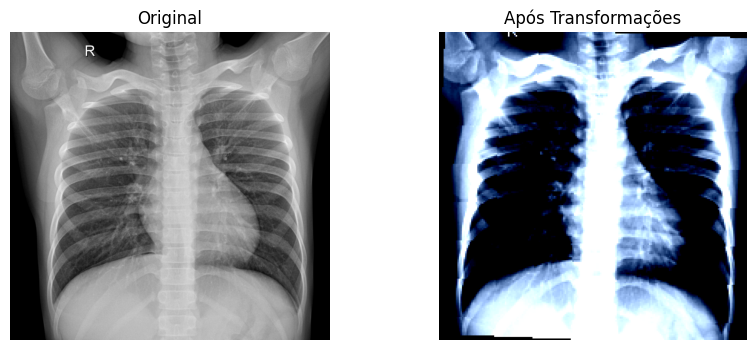

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

sample_path = train_df.loc[0, "path"]

original_img = Image.open(sample_path).convert("RGB")
processed_img = train_transform_light(original_img)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(original_img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(processed_img.permute(1,2,0))
plt.title("Após Transformações")
plt.axis("off")

plt.show()


In [12]:
# Após visualização criar .py e testar
import sys
sys.path.append(os.path.join(PROJECT_ROOT, "src"))

from dataset import XRayDataset
from transforms import get_transforms

train_transform, val_transform = get_transforms()

train_dataset = XRayDataset(train_df, transform=train_transform)

print("Tamanho do dataset:", len(train_dataset))

img, label = train_dataset[0]
print("Shape da imagem:", img.shape)
print("Label:", label)


Tamanho do dataset: 4093
Shape da imagem: torch.Size([3, 201, 201])
Label: tensor(0)


In [13]:
train_df["label"].value_counts(normalize=True)


label
1    0.735646
0    0.264354
Name: proportion, dtype: float64